# ACS analytics
In this notebok we provide experiments on the new adult-census datastes to study the discriminatory behavior of a Machine Learning model (e.g., Logsitic Regresion) on the mentioned data. We study how discriminatory the outcomes of a model trained on a state's data will be when deployed on the data of other states and further generalize the experiments on the whole US data. The discriminatory outcomes are quantified based on the "Race" protectede attribute in the sense of the difference of True-Positive Rates for three racial groups of <b>"White"</b>, <b>"non-Wthie"</b>, and <b>"Black"</b>. Then we will investigate how bias mitigation interventions can be employed and to what extent can they be efficient in terms of fair outcomes for different protected groups. 

The experiments include: 
 - Train a model on the <b>2019</b> data of the most populated state of the US, the <b>California</b>-state and deploy it on each of the states as well as the <b>whole US</b>, separately. Then comparing the outcomes (i.e., overall Accuracy and group-wise TPR difference) of the Ca-Model on different states and the whole country including the two states with the least and the most TPR-differences in the racial groups predictions (<i><b>Oklahama</i></b> & <i><b>Indiana</i></b>, respectively). The results are shown in Bar-charts and Boxplots.
 - Furthermore, I train a model on each state and deploy on all the other states including the initial state itself. It sums to n<sup>2</sup> tests. Then I summarize the distribution of the group-wise TPR differences in boxplots again in comparison with the <b>US-wide</b> model.
    
#### Next studies can be: Age and gender inequalities
 - Utilization of a fair-LR model and compare with the initial model's outcomes
 - Adding the temporal information to the problem (how to best use thses info)
 - Usage of neighborhood information to augment current task. Using a CNN, the information of neighboring states can be employed as augmentation for the current task  
 - A spatio-temporal model like the [Taxi-demand prediction](https://arxiv.org/pdf/1802.08714.pdf) 
    

In [6]:
from folktables import ACSDataSource, ACSEmployment, ACSIncome
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import os
import csv
import pickle
import itertools

### Function declarations

In [30]:
## function to sort tuples and list of lists by a specific column
## here our list is has a key and a value column).
def Sort(sub_list):
    # reverse = None (Sorts in Ascending order)
    # key is set to sort using second element of
    # sublist lambda has been used
    sub_list.sort(key=lambda x: x[1])
    return sub_list

results_path = "./results"
if not os.path.exists(results_path):
        os.makedirs(results_path)

####### function to save variables using pickle
def save_vars( *args):
    with open(os.path.join(results_path, 'variables.pkl'), 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([args], f)

def load_features(state):
    horizon = '2019_1-Year.npy'  ## 2019 data as the latest data in the repo is used
    dir = './features'  ## directory to load features from

    str1 = state + '_features_' + horizon
    str2 = state + '_group_' + horizon
    str3 = state + '_labels_' + horizon
    filename1 = os.path.join(dir, str1)
    filename2 = os.path.join(dir, str2)
    filename3 = os.path.join(dir, str3)

    # load data/features, labels and protected group
    features = np.load(filename1)
    group = np.load(filename2)
    labels = np.load(filename3)
    return features, group, labels

# function to convert list to dict. enables getting values from key-value pair
def get_list_val(stt,w,b,nw,acc,stt2='CA'):
    w_dict = dict(w)
    b_dict = dict(b)
    nw_dict = dict(nw)
    acc_dict = dict(acc)
    if stt2 == 'CA':
        return [w_dict[stt], b_dict[stt], nw_dict[stt], acc_dict[stt]]
    else:
        return [w_dict[stt], b_dict[stt], nw_dict[stt2], acc_dict[stt2]]

def bar_plot(CA_vals,stt_vals, states):
    mode = 'group'
    if mode == 'group':   ## plot group bar charts of Ca once with the min_state, once with max_state
        bar_width = 0.25
        fig, ax = plt.subplots()
        bars = ('white', 'black', 'non-white', 'total_accuracy')
        y_pos = np.arange(len(bars))
        scores = [CA_vals[0], CA_vals[1], CA_vals[2], CA_vals[3]]
        scores2 = [stt_vals[0], stt_vals[1], stt_vals[2], stt_vals[3]]

        # create the bars
        plt.barh(y_pos, scores, height=bar_width, color='green', label='Ca-state')
        plt.barh(y_pos + 0.25, scores2, height=bar_width, color='b', label=states[1]+'-state')

        # Put names in the middle of each group-bar
        ax.set_yticks(y_pos + bar_width / 2)
        ax.set_yticklabels(bars)
        # expanding the label axis to 1
        plt.xlim([0, 1])

        title = "TPRs and accuracy of a model learned on Ca \nand tested on " + states[1] + "-state"
        plt.xlabel('True Positive rates')
        plt.ylabel('Racial groups and accuracy')
        plt.title(title)
        plt.legend(loc='best', ncol=1, shadow=False)

    # the following block is to add label to the bars
    rects = ax.patches
    for rect in rects:
        # Get X and Y placement of label from rect.
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2

        # Number of points between bar and label. Change how you like.
        space = 5
        # Vertical alignment for positive values
        ha = 'left'

        # If value of bar is negative: Place label left of bar
        if x_value < 0:
            # Invert space to place label to the left
            space *= -1
            # Horizontally align label at right
            ha = 'right'

        # Use X value as label and format number with one decimal place
        label = "{:.3f}".format(x_value)

        # Create annotation
        plt.annotate(
            label,  # Use `label` as label
            (x_value, y_value),  # Place label at end of the bar
            xytext=(space, 0),  # Horizontally shift label by `space`
            textcoords="offset points",  # Interpret `xytext` as offset in points
            va='center',  # Vertically center label
            ha=ha)
    plt.tight_layout()
    plt.show()
    #plt.savefig(results_path+'//'+states[1]+'.svg', format='svg')

#-----------------------------------------------------------------------------------------------------------
    
def difference_bar(CA, min_stt, max_stt, US):
    bar_width = 0.15
    fig, ax = plt.subplots()
    bars = ('W-B diff', 'W_nW diff') #, str(max_stt)+' W-B', str(max_stt)+' W-N', 'US'+' W-B', 'US'+' W-N')
    y_pos = np.arange(len(bars))
    scores = [CA[0], CA[1]]
    scores2 = [min_stt[1], min_stt[2]]
    scores3 = [max_stt[1], max_stt[2]]
    scores4=  [US[1], US[2]]

    # create the bars
    plt.barh(y_pos, scores, height=bar_width, color='tab:green', label='Ca-state')
    plt.barh(y_pos+ bar_width, scores2, height=bar_width, color='tab:red', label=min_stt[0] + '-state')
    plt.barh(y_pos+ bar_width*2, scores3, height=bar_width, color='tab:blue', label=max_stt[0] + '-state')
    plt.barh(y_pos+ bar_width*3, scores4, height=bar_width, color='tab:orange', label='the US')

    # Put names in the middle of each group-bar
    ax.set_yticks(y_pos + bar_width*1.5)
    ax.set_yticklabels(bars)
    # expanding the label axis to 1
    plt.xlim([0, 0.5])

    title = "TPR-difference of model learned on Ca-state, tested on\n" + \
            str(min_stt[0])+", "+str(max_stt[0])+ "-states respectively, and the US"
    plt.xlabel('Difference of TPR rates')
    plt.ylabel('Racial groups per state')
    plt.title(title)
    plt.legend(loc='best', ncol=1, shadow=False)

    # the following block is to add label to the bars


    rects = ax.patches
    for rect in rects:
        # Get X and Y placement of label from rect.
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2

        # Number of points between bar and label. Change how you like.
        space = 5
        # Vertical alignment for positive values
        ha = 'left'

        # If value of bar is negative: Place label left of bar
        if x_value < 0:
            # Invert space to place label to the left
            space *= -1
            # Horizontally align label at right
            ha = 'right'

        # Use X value as label and format number with one decimal place
        label = "{:.3f}".format(x_value)

        # Create annotation
        plt.annotate(
            label,  # Use `label` as label
            (x_value, y_value),  # Place label at end of the bar
            xytext=(space, 0),  # Horizontally shift label by `space`
            textcoords="offset points",  # Interpret `xytext` as offset in points
            va='center',  # Vertically center label
            ha=ha)
    plt.tight_layout()
    plt.show()
    #plt.savefig(results_path + '//' + 'TPR-differnce.svg', format='svg')

#-------------------------------------------------------------------------------------

def produce_bp(data, title, xlabel, ylabel, differences, leg1, leg2, limit=0.27):

    fig, ax1 = plt.subplots(figsize=(10, 6))
    fig.canvas.manager.set_window_title('A Boxplot Example')
    fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

    bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+')

    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)

    ax1.set(
        axisbelow=True,  # Hide the grid behind plot objects
        title='Comparison of Black and non-White racial groups TPR difference with White groups \n'
              'over each state when model being trained on Ca-state/all_the_US data',
        xlabel=' ',
        ylabel='Difference of TPR rates',
    )

    # Now fill the boxes with desired colors
    box_colors = ['darkkhaki', 'royalblue']
    num_boxes = len(data)
    medians = np.empty(num_boxes)
    for i in range(num_boxes):
        box = bp['boxes'][i]
        box_x = []
        box_y = []
        for j in range(5):
            box_x.append(box.get_xdata()[j])
            box_y.append(box.get_ydata()[j])
        box_coords = np.column_stack([box_x, box_y])
        # Alternate between Dark Khaki and Royal Blue
        ax1.add_patch(Polygon(box_coords, facecolor=box_colors[i % 2]))
        # Now draw the median lines back over what we just filled in
        med = bp['medians'][i]
        median_x = []
        median_y = []
        for j in range(2):
            median_x.append(med.get_xdata()[j])
            median_y.append(med.get_ydata()[j])
            ax1.plot(median_x, median_y, 'k')
        medians[i] = median_y[0]
        # Finally, overplot the sample averages, with horizontal alignment
        # in the center of each box
        ax1.plot(np.average(med.get_xdata()), np.average(data[i]),
                 color='w', marker='*', markeredgecolor='k')

    # Set the axes ranges and axes labels
    ax1.set_xlim(0.5, num_boxes + 0.5)
    #top = 0.27 #max(list(itertools.chain(*data)))+ 0.05
    top = limit
    bottom = 0
    ax1.set_ylim(bottom, top)
    differences = ['Ca model W-B','US model W-B', 'Ca model W-nW', 'US model W-nW']
    #ax1.set_xticklabels(np.repeat(differences, 2), rotation=45, fontsize=8)
    ax1.set_xticklabels(differences, rotation=45, fontsize=8)

    # Due to the Y-axis scale being different across samples, it can be
    # hard to compare differences in medians across the samples. Add upper
    # X-axis tick labels with the sample medians to aid in comparison
    # (just use two decimal places of precision)
    pos = np.arange(num_boxes) + 1
    upper_labels = [str(round(s, 3)) for s in medians]
    weights = ['bold', 'semibold']
    for tick, label in zip(range(num_boxes), ax1.get_xticklabels()):
        k = tick % 2
        ax1.text(pos[tick], .95, upper_labels[tick],
                 transform=ax1.get_xaxis_transform(),
                 horizontalalignment='center', size='x-small',
                 weight=weights[k], color=box_colors[k])

    # Finally, add a basic legend
    fig.text(0.475, 0.08, 'Model trained on Ca',
             backgroundcolor=box_colors[0], color='black', weight='roman',
             size='x-small')
    fig.text(0.475, 0.045, 'Model trained on US',
             backgroundcolor=box_colors[1],
             color='white', weight='roman', size='x-small')
    fig.text(0.475, 0.010, '*', color='white', backgroundcolor='silver',
             weight='roman', size='medium')
    fig.text(0.49, 0.012, ' Average Value', color='black', weight='roman',
             size='x-small')

    plt.tight_layout()
    plt.show()
    #plt.savefig(results_path + '//' + 'bp.svg', format='svg')

In [8]:
state_list= {'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
              'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
              'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
              'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'US',
              'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR'}

## 1- California model


accuracy: model trained and tested on Ca:0.7818656659651614
also TPR for the racial groups: 
	1-white group: 0.7734233065144044
	2-black_group: 0.6692667706708268
	3-all non whites:0.6963232743669788
accuracy: model trained on Ca data and tested on SD state:0.735244040862656
also TPR of SD for 3 groups: 
	1-white group: 0.7987847222222222
	2-black_group: 0.5531914893617021
	3-all non whites:0.6507936507936508
accuracy: model trained on Ca data and tested on SD state:0.7763680135337367
also TPR of SD for 3 groups: 
	1-white group: 0.8284625158831004
	2-black_group: 0.7084745762711865
	3-all non whites:0.7511664074650077
accuracy: model trained on Ca data and tested on SD state:0.7517447657028913
also TPR of SD for 3 groups: 
	1-white group: 0.8110975112199102
	2-black_group: 0.72
	3-all non whites:0.6493738819320215
accuracy: model trained on Ca data and tested on SD state:0.7496021220159151
also TPR of SD for 3 groups: 
	1-white group: 0.8145344436033308
	2-black_group: 0.833333333333

accuracy: model trained on Ca data and tested on SD state:0.730152027027027
also TPR of SD for 3 groups: 
	1-white group: 0.7934782608695652
	2-black_group: 0.5714285714285714
	3-all non whites:0.6382978723404256
accuracy: model trained on Ca data and tested on SD state:0.7908668176940503
also TPR of SD for 3 groups: 
	1-white group: 0.8150721539283805
	2-black_group: 0.65
	3-all non whites:0.6493150684931507
accuracy: model trained on Ca data and tested on SD state:0.7380640083945436
also TPR of SD for 3 groups: 
	1-white group: 0.775178026449644
	2-black_group: 0.6290322580645161
	3-all non whites:0.6368588288697231
accuracy: model trained on Ca data and tested on SD state:0.7418633213439776
also TPR of SD for 3 groups: 
	1-white group: 0.8143190661478599
	2-black_group: 0.6852459016393443
	3-all non whites:0.702276707530648

The state with the minimum white-black TPR difference from Ca is: OK with a TPR difference rate of --> OK
and the state with the max difference is: IA with a TP

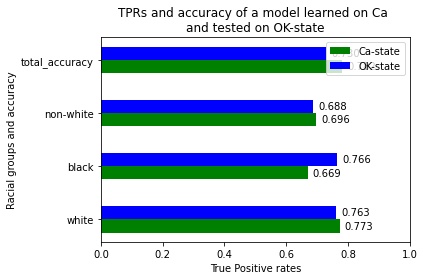

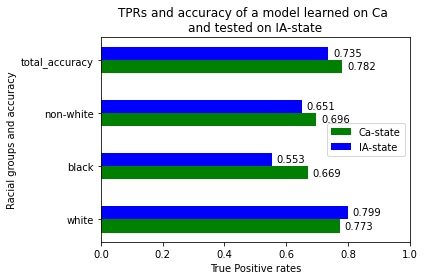

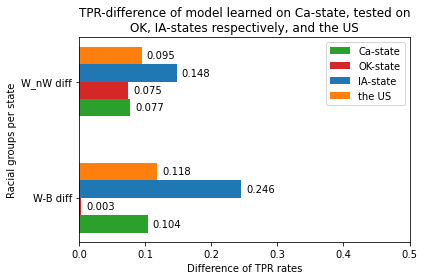

In [9]:
ca_features, ca_group, ca_labels = load_features(state= 'CA')

## train-test split of CA data
X_train_ca, X_test_ca, y_train_ca, y_test_ca, group_train_ca, group_test_ca = \
    train_test_split(ca_features, ca_labels, ca_group, test_size=0.2, random_state=0)

model = make_pipeline(StandardScaler(), LogisticRegression())
# train on training set of CA
model.fit(X_train_ca, y_train_ca)
score_ca = model.score(X_test_ca, y_test_ca)
yhat_ca = model.predict(X_test_ca)

white_tpr_ca = np.mean(yhat_ca[(y_test_ca == 1) & (group_test_ca == 1)])
black_tpr_ca = np.mean(yhat_ca[(y_test_ca == 1) & (group_test_ca == 2)])
non_white_tpr_ca = np.mean(yhat_ca[(y_test_ca == 1) & (group_test_ca != 1)])

print('\naccuracy: model trained and tested on Ca:' + str(score_ca))
print('also TPR for the racial groups: \n\t1-white group: ' + str(white_tpr_ca) + '\n\t2-black_group: '
      + str(black_tpr_ca) + '\n\t3-all non whites:' + str(non_white_tpr_ca))

CA_diff_WB = white_tpr_ca - black_tpr_ca
CA_diff_WN = white_tpr_ca - non_white_tpr_ca

# retrain using the whole CA data
model.fit(ca_features, ca_labels)

yhat_list = {}
accuracy_list = []
tpr_w_list= []
tpr_b_list= []
tpr_nw_list= []
diff_tpr_wb = []
diff_tpr_wn = []

for state in state_list:
    # load data of the state
    features, group, labels = load_features(state)

    # test the model trained on CA on other states data
    s1 = model.score(features, labels)
    # get fairness
    yhat_sd = model.predict(features)
    white_tpr_sd = np.mean(yhat_sd[(labels == 1) & (group == 1)])
    black_tpr_sd = np.mean(yhat_sd[(labels == 1) & (group == 2)])
    non_white_tpr_sd = np.mean(yhat_sd[(labels == 1) & (group != 1)])

    print('accuracy: model trained on Ca data and tested on SD state:' + str(s1))
    print('also TPR of SD for 3 groups: \n\t1-white group: ' + str(white_tpr_sd) + '\n\t2-black_group: '
          + str(black_tpr_sd) + '\n\t3-all non whites:' + str(non_white_tpr_sd))

    yhat_list['CA_'+state]= yhat_sd
    #accuracy_list['CA_'+state]=s1
    accuracy_list.append([state, s1])
    tpr_w_list.append([state, white_tpr_sd])
    tpr_b_list.append([state,black_tpr_sd])
    tpr_nw_list.append([state,non_white_tpr_sd])
    diff_tpr_wb.append([state, abs(white_tpr_sd - black_tpr_sd)])
    diff_tpr_wn.append([state, abs(white_tpr_sd - non_white_tpr_sd)])

## Sort the differences in TPR wb(white_black) and wn(white_non-white) and also accuracy
accuracy_list = Sort(accuracy_list)
diff_tpr_wb   = Sort(diff_tpr_wb)
diff_tpr_wn   = Sort(diff_tpr_wn)

min_state = diff_tpr_wb[0][0]
max_state = diff_tpr_wb[-1][0]
print("\nThe state with the minimum white-black TPR difference from Ca is: "+ str(min_state) +
      " with a TPR difference rate of --> " + str(diff_tpr_wb[0][0]) + "\nand the state with the max difference is: "
      + str(max_state) + " with a TPR difference of of --> " + str(diff_tpr_wb[-1][1]))

min_entries = np.zeros(4)
max_entries = np.zeros(4)
# list of 1-TPR_white, 2-TPR_black, 3-TPR_non-white, 4-Accuracy
min_entries = get_list_val(min_state,tpr_w_list,tpr_b_list,tpr_nw_list,accuracy_list)
max_entries = get_list_val(max_state,tpr_w_list,tpr_b_list,tpr_nw_list,accuracy_list)

bar_plot([white_tpr_ca,black_tpr_ca,non_white_tpr_ca,score_ca], min_entries,['CA',min_state])
bar_plot([white_tpr_ca, black_tpr_ca, non_white_tpr_ca, score_ca], max_entries,['CA',max_state])

entries = get_list_val(min_state, diff_tpr_wb, diff_tpr_wn, diff_tpr_wb, diff_tpr_wn, max_state)
US_entries = get_list_val('US', diff_tpr_wb, diff_tpr_wn, diff_tpr_wb, diff_tpr_wn)
difference_bar([CA_diff_WB,CA_diff_WN], [min_state,entries[0], entries[1]],
               [max_state,entries[2], entries[3]], ['US',US_entries[0],US_entries[1]])


#### save predictions

In [ ]:
""" saves 1-"CA predicted labels", 2-"CA accuracy", 3- "CA white-black diff", 4-"CA white-nonwhite", 5-"CA TPR white", 
6-"CA TPR black", 7-"CA TPR non-white",  trained on CA & test on states--> 8-"all predicted labels", 9-"all accuracy"
10- "all TPR diff WB",  11-"all TPR diff WN" ,12"all TPR white", 13-"all TPR black", 14-"all TPR nw" """
save_vars(yhat_ca, score_ca, CA_diff_WB, CA_diff_WN ,white_tpr_ca, black_tpr_ca, non_white_tpr_ca,
          yhat_list, accuracy_list, diff_tpr_wb, diff_tpr_wn, tpr_w_list, tpr_b_list, tpr_nw_list)

### US-wide model 

In [10]:
## US-wide model deployed on each state

us_features, us_group, us_labels = load_features(state= 'US')

## train-test split of the US data
X_train_us, X_test_us, y_train_us, y_test_us, group_train_us, group_test_us = \
    train_test_split(us_features, us_labels, us_group, test_size=0.2, random_state=0)

model = make_pipeline(StandardScaler(), LogisticRegression())
# train on training set of the US
model.fit(X_train_us, y_train_us)
score_us = model.score(X_test_us, y_test_us)
yhat_us = model.predict(X_test_us)

white_tpr_us = np.mean(yhat_us[(y_test_us == 1) & (group_test_us == 1)])
black_tpr_us= np.mean(yhat_us[(y_test_us == 1) & (group_test_us == 2)])
non_white_tpr_us = np.mean(yhat_us[(y_test_us == 1) & (group_test_us != 1)])

print('\naccuracy: model trained and tested on Ca:' + str(score_ca))
print('also TPR for the racial groups: \n\t1-white group: ' + str(white_tpr_ca) + '\n\t2-black_group: '
      + str(black_tpr_ca) + '\n\t3-all non whites:' + str(non_white_tpr_ca))

US_diff_WB = white_tpr_us - black_tpr_us
US_diff_WN = white_tpr_us - non_white_tpr_us

# retrain using the whole US data
model.fit(us_features, us_labels)

i=0
yhat_list = {}
accuracy_list = []
tpr_w_list= []
tpr_b_list= []
tpr_nw_list= []
diff_tpr_wb_us = []
diff_tpr_wn_us = []

for state in state_list:
    # load data of the state
    features, group, labels = load_features(state)

    # test the model trained on the US on other states data
    s1 = model.score(features, labels)
    # get fairness
    yhat_sd = model.predict(features)
    white_tpr_sd = np.mean(yhat_sd[(labels == 1) & (group == 1)])
    black_tpr_sd = np.mean(yhat_sd[(labels == 1) & (group == 2)])
    non_white_tpr_sd = np.mean(yhat_sd[(labels == 1) & (group != 1)])

    print('accuracy: model trained on US data and tested on SD state:' + str(s1))
    print('also TPR of SD for 3 groups: \n\t1-white group: ' + str(white_tpr_sd) + '\n\t2-black_group: '
          + str(black_tpr_sd) + '\n\t3-all non whites:' + str(non_white_tpr_sd))

    yhat_list['US_'+state]= yhat_sd
    accuracy_list.append([state, s1])
    tpr_w_list.append([state, white_tpr_sd])
    tpr_b_list.append([state,black_tpr_sd])
    tpr_nw_list.append([state,non_white_tpr_sd])
    diff_tpr_wb_us.append([state, abs(white_tpr_sd - black_tpr_sd)])
    diff_tpr_wn_us.append([state, abs(white_tpr_sd - non_white_tpr_sd)])

## Sort the differences in TPR wb(white_black) and wn(white_non-white) and also accuracy
accuracy_list = Sort(accuracy_list)
diff_tpr_wb_us   = Sort(diff_tpr_wb_us)
diff_tpr_wn_us   = Sort(diff_tpr_wn_us)



accuracy: model trained and tested on Ca:0.7818656659651614
also TPR for the racial groups: 
	1-white group: 0.7734233065144044
	2-black_group: 0.6692667706708268
	3-all non whites:0.6963232743669788
accuracy: model trained on US data and tested on SD state:0.7675936435868331
also TPR of SD for 3 groups: 
	1-white group: 0.6767361111111111
	2-black_group: 0.3617021276595745
	3-all non whites:0.5343915343915344
accuracy: model trained on US data and tested on SD state:0.7805105515431496
also TPR of SD for 3 groups: 
	1-white group: 0.7308646457312277
	2-black_group: 0.5907990314769975
	3-all non whites:0.6678515885358809
accuracy: model trained on US data and tested on SD state:0.7757837598316163
also TPR of SD for 3 groups: 
	1-white group: 0.7029783761729906
	2-black_group: 0.58
	3-all non whites:0.5474060822898033
accuracy: model trained on US data and tested on SD state:0.7758620689655172
also TPR of SD for 3 groups: 
	1-white group: 0.7032551097653293
	2-black_group: 0.83333333333

#### save the variables 

In [ ]:
# again save the variables now for the model learned on the whole US deployed on each state
save_vars(yhat_us, score_us, US_diff_WB, US_diff_WN ,white_tpr_us, black_tpr_us, non_white_tpr_us,
          yhat_list, accuracy_list, diff_tpr_wb_us, diff_tpr_wn_us, tpr_w_list, tpr_b_list, tpr_nw_list)

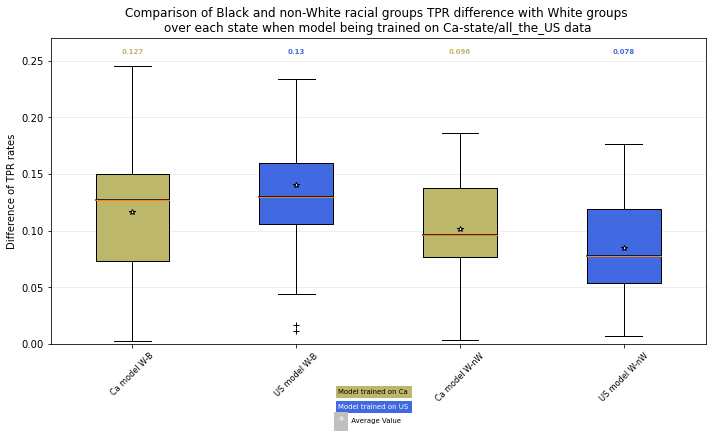

In [32]:
# producing boxplots

data = [list(dict(diff_tpr_wb).values()), list(dict(diff_tpr_wb_us).values()),
        list(dict(diff_tpr_wn).values()), list(dict(diff_tpr_wn_us).values())]

title='Comparison of Black and non-White racial groups TPR difference with White groups \n' \
      'over each state when model being trained on Ca-state/all_the_US data'
xlabel=' '
ylabel='Difference of TPR rates'
differences = ['Ca model W-B','US model W-B', 'Ca model W-nW', 'US model W-nW']
leg1='Model trained on Ca'
leg2= 'Model trained on US'
limit = 0.27

produce_bp(data, title, xlabel, ylabel, differences, leg1, leg2, limit)

#### same chart as the upper one including outliers

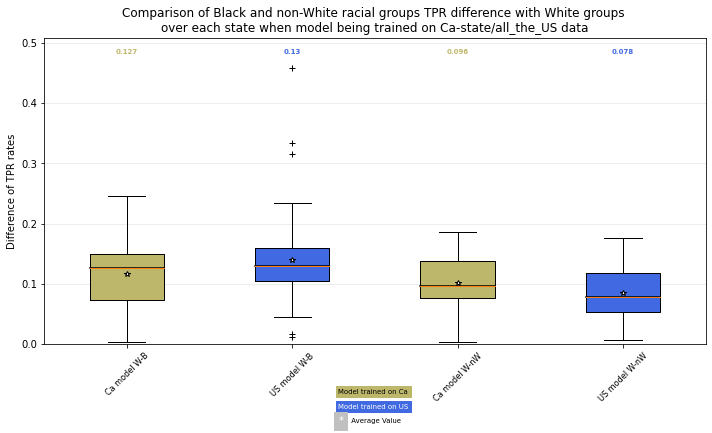

In [31]:
# producing boxplots

data = [list(dict(diff_tpr_wb).values()), list(dict(diff_tpr_wb_us).values()),
        list(dict(diff_tpr_wn).values()), list(dict(diff_tpr_wn_us).values())]

title='Comparison of Black and non-White racial groups TPR difference with White groups \n' \
      'over each state when model being trained on Ca-state/all_the_US data'
xlabel=' '
ylabel='Difference of TPR rates'
differences = ['Ca model W-B','US model W-B', 'Ca model W-nW', 'US model W-nW']
leg1='Model trained on Ca'
leg2= 'Model trained on US'
limit = max(list(itertools.chain(*data)))+ 0.05

produce_bp(data, title, xlabel, ylabel, differences, leg1, leg2, limit)

## 2- State-wise model comparisons

In [33]:
yhat_list_n2 = {}
accuracy_list_n2 = []
tpr_w_list_n2 = []
tpr_b_list_n2 = []
tpr_nw_list_n2 = []
diff_tpr_wb_n2 = []
diff_tpr_wn_n2 = []

for state_itr in state_list:
    # load data of the state_itr
    new_features, new_group, new_labels = load_features(state_itr)
    model = make_pipeline(StandardScaler(), LogisticRegression())
    # train using the new_state data
    model.fit(new_features, new_labels)

    for state in state_list:
        # load data of the state
        features, group, labels = load_features(state)

        # test the model trained on new_state, on the other states data
        s1 = model.score(features, labels)
        # get fairness
        yhat_sd = model.predict(features)
        white_tpr_sd = np.mean(yhat_sd[(labels == 1) & (group == 1)])
        black_tpr_sd = np.mean(yhat_sd[(labels == 1) & (group == 2)])
        non_white_tpr_sd = np.mean(yhat_sd[(labels == 1) & (group != 1)])

        print(f'accuracy of model trained on {state_itr}'+ f' data and tested on {state} state:\n' + str(s1))
        print(f'also TPR of {state} for 3 groups: \n\t1-white group: ' + str(white_tpr_sd) + '\n\t2-black_group: '
              + str(black_tpr_sd) + '\n\t3-all non whites:' + str(non_white_tpr_sd))

        yhat_list_n2[f'{state_itr}_'+state]= yhat_sd
        accuracy_list_n2.append([state, s1])
        tpr_w_list_n2.append([state, white_tpr_sd])
        tpr_b_list_n2.append([state,black_tpr_sd])
        tpr_nw_list_n2.append([state,non_white_tpr_sd])
        diff_tpr_wb_n2.append([state, abs(white_tpr_sd - black_tpr_sd)])
        diff_tpr_wn_n2.append([state, abs(white_tpr_sd - non_white_tpr_sd)])

## Sort the differences in TPR wb(white_black) and wn(white_non-white) and also accuracy
accuracy_list_n2 = Sort(accuracy_list_n2)
diff_tpr_wb_n2   = Sort(diff_tpr_wb_n2)
diff_tpr_wn_n2   = Sort(diff_tpr_wn_n2)


accuracy of model trained on IA data and tested on IA state:
0.7695800227014756
also TPR of IA for 3 groups: 
	1-white group: 0.5625
	2-black_group: 0.2978723404255319
	3-all non whites:0.3862433862433862
accuracy of model trained on IA data and tested on VA state:
0.7515127854772594
also TPR of VA for 3 groups: 
	1-white group: 0.6036183215344587
	2-black_group: 0.43631961259079904
	3-all non whites:0.4941124194623417
accuracy of model trained on IA data and tested on NM state:
0.7716849451645065
also TPR of NM for 3 groups: 
	1-white group: 0.5744594043247654
	2-black_group: 0.46
	3-all non whites:0.38998211091234347
accuracy of model trained on IA data and tested on VT state:
0.7657824933687003
also TPR of VT for 3 groups: 
	1-white group: 0.5639666919000756
	2-black_group: 0.6666666666666666
	3-all non whites:0.6756756756756757
accuracy of model trained on IA data and tested on OH state:
0.7738076068403594
also TPR of OH for 3 groups: 
	1-white group: 0.5505722390687665
	2-black_gr

accuracy of model trained on VA data and tested on IA state:
0.7593643586833144
also TPR of IA for 3 groups: 
	1-white group: 0.7340277777777777
	2-black_group: 0.425531914893617
	3-all non whites:0.5925925925925926
accuracy of model trained on VA data and tested on VA state:
0.7823540894007418
also TPR of VA for 3 groups: 
	1-white group: 0.7797543413807708
	2-black_group: 0.6455205811138015
	3-all non whites:0.7109531215285492
accuracy of model trained on VA data and tested on NM state:
0.769247812119198
also TPR of NM for 3 groups: 
	1-white group: 0.7649938800489596
	2-black_group: 0.64
	3-all non whites:0.6153846153846154
accuracy of model trained on VA data and tested on VT state:
0.76657824933687
also TPR of VT for 3 groups: 
	1-white group: 0.7577592732778198
	2-black_group: 0.8333333333333334
	3-all non whites:0.8108108108108109
accuracy of model trained on VA data and tested on OH state:
0.7797333419213552
also TPR of OH for 3 groups: 
	1-white group: 0.7191626724053605
	2-bl

accuracy of model trained on NM data and tested on IA state:
0.7653802497162315
also TPR of IA for 3 groups: 
	1-white group: 0.5715277777777777
	2-black_group: 0.2765957446808511
	3-all non whites:0.3544973544973545
accuracy of model trained on NM data and tested on VA state:
0.7587568048235626
also TPR of VA for 3 groups: 
	1-white group: 0.6343559024626368
	2-black_group: 0.47312348668280874
	3-all non whites:0.5007776049766719
accuracy of model trained on NM data and tested on NM state:
0.7748975296333223
also TPR of NM for 3 groups: 
	1-white group: 0.6111791105671155
	2-black_group: 0.52
	3-all non whites:0.38998211091234347
accuracy of model trained on NM data and tested on VT state:
0.7687002652519894
also TPR of VT for 3 groups: 
	1-white group: 0.6025738077214232
	2-black_group: 0.8333333333333334
	3-all non whites:0.7027027027027027
accuracy of model trained on NM data and tested on OH state:
0.7778332420856011
also TPR of OH for 3 groups: 
	1-white group: 0.5708206984251198

accuracy of model trained on NM data and tested on LA state:
0.7594391539455424
also TPR of LA for 3 groups: 
	1-white group: 0.5760512483574245
	2-black_group: 0.4242973708068903
	3-all non whites:0.4292682926829268
accuracy of model trained on NM data and tested on SC state:
0.7807454654175803
also TPR of SC for 3 groups: 
	1-white group: 0.6178256070640177
	2-black_group: 0.4264538198403649
	3-all non whites:0.42810457516339867
accuracy of model trained on NM data and tested on MS state:
0.7818983205410746
also TPR of MS for 3 groups: 
	1-white group: 0.6102204408817635
	2-black_group: 0.4628482972136223
	3-all non whites:0.4676354029062087
accuracy of model trained on NM data and tested on AR state:
0.7826148610323312
also TPR of AR for 3 groups: 
	1-white group: 0.5846854540278964
	2-black_group: 0.38223938223938225
	3-all non whites:0.40707964601769914
accuracy of model trained on NM data and tested on ID state:
0.7769733769266698
also TPR of ID for 3 groups: 
	1-white group: 0.5

accuracy of model trained on VT data and tested on US state:
0.7665221551157089
also TPR of US for 3 groups: 
	1-white group: 0.6250508411228651
	2-black_group: 0.45364695065890287
	3-all non whites:0.4994531784005468
accuracy of model trained on VT data and tested on FL state:
0.772867584091769
also TPR of FL for 3 groups: 
	1-white group: 0.6374546286910173
	2-black_group: 0.4523905182804339
	3-all non whites:0.4942696395082309
accuracy of model trained on VT data and tested on MA state:
0.7549890499274097
also TPR of MA for 3 groups: 
	1-white group: 0.6296978417266187
	2-black_group: 0.3610698365527489
	3-all non whites:0.5291592128801431
accuracy of model trained on VT data and tested on WI state:
0.7561448900388098
also TPR of WI for 3 groups: 
	1-white group: 0.5780959957570936
	2-black_group: 0.46296296296296297
	3-all non whites:0.5009276437847866
accuracy of model trained on VT data and tested on PR state:
0.8188781014023733
also TPR of PR for 3 groups: 
	1-white group: 0.692

accuracy of model trained on OH data and tested on KY state:
0.7838931054856156
also TPR of KY for 3 groups: 
	1-white group: 0.6631070801638385
	2-black_group: 0.56
	3-all non whites:0.5893909626719057
accuracy of model trained on OH data and tested on NH state:
0.7623687207389599
also TPR of NH for 3 groups: 
	1-white group: 0.67506832675372
	2-black_group: 0.6
	3-all non whites:0.6139240506329114
accuracy of model trained on OH data and tested on GA state:
0.7807258190939018
also TPR of GA for 3 groups: 
	1-white group: 0.7103279690364637
	2-black_group: 0.5464998309097058
	3-all non whites:0.5596558750282997
accuracy of model trained on OH data and tested on DE state:
0.7608832807570978
also TPR of DE for 3 groups: 
	1-white group: 0.6567255021302495
	2-black_group: 0.47346938775510206
	3-all non whites:0.5061124694376528
accuracy of model trained on OH data and tested on KS state:
0.7690749066041918
also TPR of KS for 3 groups: 
	1-white group: 0.6964140179299103
	2-black_group: 0

accuracy of model trained on NV data and tested on NE state:
0.7465791420118343
also TPR of NE for 3 groups: 
	1-white group: 0.7192230791202514
	2-black_group: 0.6415094339622641
	3-all non whites:0.4808743169398907
accuracy of model trained on NV data and tested on TN state:
0.7809018258181182
also TPR of TN for 3 groups: 
	1-white group: 0.7071435532599162
	2-black_group: 0.5731132075471698
	3-all non whites:0.5672782874617737
accuracy of model trained on NV data and tested on TX state:
0.7725842956621087
also TPR of TX for 3 groups: 
	1-white group: 0.6987708595011664
	2-black_group: 0.5711079943899018
	3-all non whites:0.5430325736288896
accuracy of model trained on NV data and tested on WV state:
0.7660696761530913
also TPR of WV for 3 groups: 
	1-white group: 0.6513798701298701
	2-black_group: 0.52
	3-all non whites:0.6019417475728155
accuracy of model trained on NV data and tested on ND state:
0.7358024691358025
also TPR of ND for 3 groups: 
	1-white group: 0.676761433868974
	2

also TPR of NJ for 3 groups: 
	1-white group: 0.7729377104377104
	2-black_group: 0.5959902794653706
	3-all non whites:0.7116150250995327
accuracy of model trained on WA data and tested on AZ state:
0.7654924220258645
also TPR of AZ for 3 groups: 
	1-white group: 0.7851075877689694
	2-black_group: 0.729050279329609
	3-all non whites:0.685807150595883
accuracy of model trained on WA data and tested on RI state:
0.7839797639123103
also TPR of RI for 3 groups: 
	1-white group: 0.7810924369747899
	2-black_group: 0.6229508196721312
	3-all non whites:0.6448598130841121
accuracy of model trained on WA data and tested on NY state:
0.7625515192178663
also TPR of NY for 3 groups: 
	1-white group: 0.7588614990818541
	2-black_group: 0.5525846702317291
	3-all non whites:0.6073478760045924
accuracy of model trained on WA data and tested on SD state:
0.7189331178015761
also TPR of SD for 3 groups: 
	1-white group: 0.8176312247644684
	2-black_group: 0.5
	3-all non whites:0.631578947368421
accuracy of m

accuracy of model trained on IL data and tested on IL state:
0.7653328488592148
also TPR of IL for 3 groups: 
	1-white group: 0.7060252258394409
	2-black_group: 0.5380804953560372
	3-all non whites:0.6263403263403263
accuracy of model trained on IL data and tested on WY state:
0.7469879518072289
also TPR of WY for 3 groups: 
	1-white group: 0.6763110307414105
	2-black_group: 0.6
	3-all non whites:0.5454545454545454
accuracy of model trained on IL data and tested on MO state:
0.7629554591788281
also TPR of MO for 3 groups: 
	1-white group: 0.7048489829463735
	2-black_group: 0.5844660194174758
	3-all non whites:0.6485042735042735
accuracy of model trained on IL data and tested on MD state:
0.7707591662863228
also TPR of MD for 3 groups: 
	1-white group: 0.7399745654938533
	2-black_group: 0.5819854107199492
	3-all non whites:0.6168818272095332
accuracy of model trained on IL data and tested on NJ state:
0.7630441526212387
also TPR of NJ for 3 groups: 
	1-white group: 0.6966540404040404
	2

accuracy of model trained on IL data and tested on AL state:
0.7717343626633916
also TPR of AL for 3 groups: 
	1-white group: 0.7324513618677043
	2-black_group: 0.5759562841530055
	3-all non whites:0.6085814360770578
accuracy of model trained on WY data and tested on IA state:
0.7574914869466516
also TPR of IA for 3 groups: 
	1-white group: 0.6293402777777778
	2-black_group: 0.3191489361702128
	3-all non whites:0.37037037037037035
accuracy of model trained on WY data and tested on VA state:
0.7411889734747436
also TPR of VA for 3 groups: 
	1-white group: 0.6136019846312095
	2-black_group: 0.4542372881355932
	3-all non whites:0.46100866474116864
accuracy of model trained on WY data and tested on NM state:
0.763487315830287
also TPR of NM for 3 groups: 
	1-white group: 0.6030191758465933
	2-black_group: 0.48
	3-all non whites:0.3774597495527728
accuracy of model trained on WY data and tested on VT state:
0.7527851458885941
also TPR of VT for 3 groups: 
	1-white group: 0.5934897804693414


accuracy of model trained on WY data and tested on AL state:
0.7722607246249671
also TPR of AL for 3 groups: 
	1-white group: 0.6621011673151751
	2-black_group: 0.4666666666666667
	3-all non whites:0.4763572679509632
accuracy of model trained on MO data and tested on IA state:
0.7672531214528945
also TPR of IA for 3 groups: 
	1-white group: 0.5576388888888889
	2-black_group: 0.3404255319148936
	3-all non whites:0.38095238095238093
accuracy of model trained on MO data and tested on VA state:
0.7555685687639621
also TPR of VA for 3 groups: 
	1-white group: 0.6200157318327585
	2-black_group: 0.4547215496368039
	3-all non whites:0.5027771606309709
accuracy of model trained on MO data and tested on NM state:
0.774122078209815
also TPR of NM for 3 groups: 
	1-white group: 0.5903712770297838
	2-black_group: 0.48
	3-all non whites:0.3631484794275492
accuracy of model trained on MO data and tested on VT state:
0.7697612732095491
also TPR of VT for 3 groups: 
	1-white group: 0.5813777441332324
	

accuracy of model trained on MD data and tested on IA state:
0.7317820658342792
also TPR of IA for 3 groups: 
	1-white group: 0.8090277777777778
	2-black_group: 0.5957446808510638
	3-all non whites:0.6666666666666666
accuracy of model trained on MD data and tested on VA state:
0.7751751360964713
also TPR of VA for 3 groups: 
	1-white group: 0.83838567193078
	2-black_group: 0.7278450363196126
	3-all non whites:0.7687180626527438
accuracy of model trained on MD data and tested on NM state:
0.7450980392156863
also TPR of NM for 3 groups: 
	1-white group: 0.8225214198286414
	2-black_group: 0.72
	3-all non whites:0.6815742397137746
accuracy of model trained on MD data and tested on VT state:
0.7403183023872679
also TPR of VT for 3 groups: 
	1-white group: 0.8327024981074943
	2-black_group: 0.8333333333333334
	3-all non whites:0.8378378378378378
accuracy of model trained on MD data and tested on OH state:
0.7629383916782069
also TPR of OH for 3 groups: 
	1-white group: 0.7931135674459552
	2-

accuracy of model trained on MD data and tested on AR state:
0.7272404991491775
also TPR of AR for 3 groups: 
	1-white group: 0.8087105038428694
	2-black_group: 0.637065637065637
	3-all non whites:0.668141592920354
accuracy of model trained on MD data and tested on ID state:
0.7375058383932742
also TPR of ID for 3 groups: 
	1-white group: 0.8044715447154471
	2-black_group: 0.75
	3-all non whites:0.7266187050359713
accuracy of model trained on MD data and tested on ME state:
0.7215653153153153
also TPR of ME for 3 groups: 
	1-white group: 0.8134057971014492
	2-black_group: 0.5714285714285714
	3-all non whites:0.6808510638297872
accuracy of model trained on MD data and tested on UT state:
0.7886014069393108
also TPR of UT for 3 groups: 
	1-white group: 0.8230892570817745
	2-black_group: 0.65
	3-all non whites:0.6904109589041096
accuracy of model trained on MD data and tested on HI state:
0.7360965372507869
also TPR of HI for 3 groups: 
	1-white group: 0.7873855544252288
	2-black_group: 0

accuracy of model trained on NJ data and tested on US state:
0.7507827542904981
also TPR of US for 3 groups: 
	1-white group: 0.832248112008032
	2-black_group: 0.7130707937480846
	3-all non whites:0.7444463431305537
accuracy of model trained on NJ data and tested on FL state:
0.7346304741799933
also TPR of FL for 3 groups: 
	1-white group: 0.8399659919557896
	2-black_group: 0.7107271996785858
	3-all non whites:0.7514065430297979
accuracy of model trained on NJ data and tested on MA state:
0.7843696941361746
also TPR of MA for 3 groups: 
	1-white group: 0.8254388489208633
	2-black_group: 0.6240713224368499
	3-all non whites:0.7402504472271915
accuracy of model trained on NJ data and tested on WI state:
0.725836259471447
also TPR of WI for 3 groups: 
	1-white group: 0.8163175108282507
	2-black_group: 0.7160493827160493
	3-all non whites:0.7458256029684601
accuracy of model trained on NJ data and tested on PR state:
0.6674217907227616
also TPR of PR for 3 groups: 
	1-white group: 0.862190

accuracy of model trained on AZ data and tested on GA state:
0.7816664053926948
also TPR of GA for 3 groups: 
	1-white group: 0.6948462008555714
	2-black_group: 0.5397362191410213
	3-all non whites:0.5698437853746887
accuracy of model trained on AZ data and tested on DE state:
0.7585699263932703
also TPR of DE for 3 groups: 
	1-white group: 0.642726719415703
	2-black_group: 0.45714285714285713
	3-all non whites:0.511002444987775
accuracy of model trained on AZ data and tested on KS state:
0.7693281833723802
also TPR of KS for 3 groups: 
	1-white group: 0.669519152404238
	2-black_group: 0.5104895104895105
	3-all non whites:0.5653153153153153
accuracy of model trained on AZ data and tested on OK state:
0.766947723440135
also TPR of OK for 3 groups: 
	1-white group: 0.6027336860670194
	2-black_group: 0.5957446808510638
	3-all non whites:0.5235294117647059
accuracy of model trained on AZ data and tested on US state:
0.7679674699515637
also TPR of US for 3 groups: 
	1-white group: 0.6471186

accuracy of model trained on RI data and tested on CA state:
0.7745305360737957
also TPR of CA for 3 groups: 
	1-white group: 0.7378323036804985
	2-black_group: 0.6388182973316391
	3-all non whites:0.5998160700296331
accuracy of model trained on RI data and tested on OR state:
0.767187785701225
also TPR of OR for 3 groups: 
	1-white group: 0.757579734873343
	2-black_group: 0.711340206185567
	3-all non whites:0.6204128440366973
accuracy of model trained on RI data and tested on CO state:
0.7645053310190925
also TPR of CO for 3 groups: 
	1-white group: 0.7990128027147926
	2-black_group: 0.6681614349775785
	3-all non whites:0.6638526477359938
accuracy of model trained on RI data and tested on MI state:
0.7679247152055473
also TPR of MI for 3 groups: 
	1-white group: 0.7853422391077884
	2-black_group: 0.6372997711670481
	3-all non whites:0.6481766820749871
accuracy of model trained on RI data and tested on NE state:
0.7284578402366864
also TPR of NE for 3 groups: 
	1-white group: 0.8091973

accuracy of model trained on NY data and tested on SD state:
0.7213578500707214
also TPR of SD for 3 groups: 
	1-white group: 0.7853297442799462
	2-black_group: 0.5
	3-all non whites:0.631578947368421
accuracy of model trained on NY data and tested on MT state:
0.7184063457724896
also TPR of MT for 3 groups: 
	1-white group: 0.770135214579659
	2-black_group: 0.75
	3-all non whites:0.6774193548387096
accuracy of model trained on NY data and tested on MN state:
0.7463111737029094
also TPR of MN for 3 groups: 
	1-white group: 0.7538525269262635
	2-black_group: 0.6830985915492958
	3-all non whites:0.6959761549925484
accuracy of model trained on NY data and tested on CA state:
0.7808492187856567
also TPR of CA for 3 groups: 
	1-white group: 0.748280508934353
	2-black_group: 0.6531130876747141
	3-all non whites:0.6734561803876153
accuracy of model trained on NY data and tested on OR state:
0.7696562442859755
also TPR of OR for 3 groups: 
	1-white group: 0.7571859824123901
	2-black_group: 0.7

accuracy of model trained on SD data and tested on WY state:
0.7327203551046291
also TPR of WY for 3 groups: 
	1-white group: 0.43037974683544306
	2-black_group: 0.4
	3-all non whites:0.3787878787878788
accuracy of model trained on SD data and tested on MO state:
0.7568457374402482
also TPR of MO for 3 groups: 
	1-white group: 0.4623998356276967
	2-black_group: 0.2970873786407767
	3-all non whites:0.36645299145299143
accuracy of model trained on SD data and tested on MD state:
0.6794462193823216
also TPR of MD for 3 groups: 
	1-white group: 0.4871555743959305
	2-black_group: 0.2752933713923248
	3-all non whites:0.3058589870903674
accuracy of model trained on SD data and tested on NJ state:
0.6754213628373488
also TPR of NJ for 3 groups: 
	1-white group: 0.4441287878787879
	2-black_group: 0.23390036452004861
	3-all non whites:0.34204604465985805
accuracy of model trained on SD data and tested on AZ state:
0.7546667446895664
also TPR of AZ for 3 groups: 
	1-white group: 0.478765571913929

accuracy of model trained on MT data and tested on WY state:
0.7285986049461002
also TPR of WY for 3 groups: 
	1-white group: 0.42224231464737794
	2-black_group: 0.6
	3-all non whites:0.3333333333333333
accuracy of model trained on MT data and tested on MO state:
0.7596631738896451
also TPR of MO for 3 groups: 
	1-white group: 0.4612697760427368
	2-black_group: 0.32233009708737864
	3-all non whites:0.3803418803418803
accuracy of model trained on MT data and tested on MD state:
0.6894568690095847
also TPR of MD for 3 groups: 
	1-white group: 0.50996184824078
	2-black_group: 0.3054234062797336
	3-all non whites:0.333862959285005
accuracy of model trained on MT data and tested on NJ state:
0.6860717609347534
also TPR of NJ for 3 groups: 
	1-white group: 0.468013468013468
	2-black_group: 0.27278250303766705
	3-all non whites:0.3853211009174312
accuracy of model trained on MT data and tested on AZ state:
0.7591433085610627
also TPR of AZ for 3 groups: 
	1-white group: 0.49226123065307664
	2

accuracy of model trained on MN data and tested on IL state:
0.7632889736718597
also TPR of IL for 3 groups: 
	1-white group: 0.6779444349752854
	2-black_group: 0.4804953560371517
	3-all non whites:0.5571095571095571
accuracy of model trained on MN data and tested on WY state:
0.7466708941027267
also TPR of WY for 3 groups: 
	1-white group: 0.6455696202531646
	2-black_group: 0.6
	3-all non whites:0.4393939393939394
accuracy of model trained on MN data and tested on MO state:
0.768115483237836
also TPR of MO for 3 groups: 
	1-white group: 0.6758783644955825
	2-black_group: 0.5262135922330097
	3-all non whites:0.5854700854700855
accuracy of model trained on MN data and tested on MD state:
0.7569146508443633
also TPR of MD for 3 groups: 
	1-white group: 0.7075031793132683
	2-black_group: 0.5125277513479226
	3-all non whites:0.5374379344587885
accuracy of model trained on MN data and tested on NJ state:
0.7527453210629718
also TPR of NJ for 3 groups: 
	1-white group: 0.6676662457912458
	2-

accuracy of model trained on CA data and tested on IA state:
0.735244040862656
also TPR of IA for 3 groups: 
	1-white group: 0.7987847222222222
	2-black_group: 0.5531914893617021
	3-all non whites:0.6507936507936508
accuracy of model trained on CA data and tested on VA state:
0.7763680135337367
also TPR of VA for 3 groups: 
	1-white group: 0.8284625158831004
	2-black_group: 0.7084745762711865
	3-all non whites:0.7511664074650077
accuracy of model trained on CA data and tested on NM state:
0.7517447657028913
also TPR of NM for 3 groups: 
	1-white group: 0.8110975112199102
	2-black_group: 0.72
	3-all non whites:0.6493738819320215
accuracy of model trained on CA data and tested on VT state:
0.7496021220159151
also TPR of VT for 3 groups: 
	1-white group: 0.8145344436033308
	2-black_group: 0.8333333333333334
	3-all non whites:0.8108108108108109
accuracy of model trained on CA data and tested on OH state:
0.7645647483172845
also TPR of OH for 3 groups: 
	1-white group: 0.7872933581140565
	2

also TPR of MS for 3 groups: 
	1-white group: 0.8069472277889111
	2-black_group: 0.6625386996904025
	3-all non whites:0.6697490092470277
accuracy of model trained on CA data and tested on AR state:
0.7325581395348837
also TPR of AR for 3 groups: 
	1-white group: 0.7947623114147452
	2-black_group: 0.6254826254826255
	3-all non whites:0.6570796460176991
accuracy of model trained on CA data and tested on ID state:
0.7406585707613265
also TPR of ID for 3 groups: 
	1-white group: 0.7882113821138211
	2-black_group: 0.75
	3-all non whites:0.6906474820143885
accuracy of model trained on CA data and tested on ME state:
0.730152027027027
also TPR of ME for 3 groups: 
	1-white group: 0.7934782608695652
	2-black_group: 0.5714285714285714
	3-all non whites:0.6382978723404256
accuracy of model trained on CA data and tested on UT state:
0.7908668176940503
also TPR of UT for 3 groups: 
	1-white group: 0.8150721539283805
	2-black_group: 0.65
	3-all non whites:0.6493150684931507
accuracy of model traine

accuracy of model trained on OR data and tested on US state:
0.771466244094959
also TPR of US for 3 groups: 
	1-white group: 0.6985295464788629
	2-black_group: 0.5495454081111452
	3-all non whites:0.5814166097060834
accuracy of model trained on OR data and tested on FL state:
0.7674307450261885
also TPR of FL for 3 groups: 
	1-white group: 0.7163271312252706
	2-black_group: 0.5572519083969466
	3-all non whites:0.5911648260054178
accuracy of model trained on OR data and tested on MA state:
0.7725337729766972
also TPR of MA for 3 groups: 
	1-white group: 0.6966330935251799
	2-black_group: 0.4933135215453195
	3-all non whites:0.6153846153846154
accuracy of model trained on OR data and tested on WI state:
0.7552824493316085
also TPR of WI for 3 groups: 
	1-white group: 0.6619817908600725
	2-black_group: 0.5370370370370371
	3-all non whites:0.5658627087198516
accuracy of model trained on OR data and tested on PR state:
0.7765911542610572
also TPR of PR for 3 groups: 
	1-white group: 0.77502

accuracy of model trained on CO data and tested on TX state:
0.776481817590189
also TPR of TX for 3 groups: 
	1-white group: 0.7242284227525569
	2-black_group: 0.617671809256662
	3-all non whites:0.6512644395878864
accuracy of model trained on CO data and tested on WV state:
0.7639842983316978
also TPR of WV for 3 groups: 
	1-white group: 0.6627435064935064
	2-black_group: 0.52
	3-all non whites:0.6213592233009708
accuracy of model trained on CO data and tested on ND state:
0.7380471380471381
also TPR of ND for 3 groups: 
	1-white group: 0.6872682323856613
	2-black_group: 1.0
	3-all non whites:0.6231884057971014
accuracy of model trained on CO data and tested on KY state:
0.7774848884243057
also TPR of KY for 3 groups: 
	1-white group: 0.7033352837916911
	2-black_group: 0.6254545454545455
	3-all non whites:0.6719056974459725
accuracy of model trained on CO data and tested on NH state:
0.767303555611793
also TPR of NH for 3 groups: 
	1-white group: 0.7191011235955056
	2-black_group: 0.6

accuracy of model trained on MI data and tested on CA state:
0.760265323819811
also TPR of CA for 3 groups: 
	1-white group: 0.6163916064334343
	2-black_group: 0.4939644218551461
	3-all non whites:0.5767907626281549
accuracy of model trained on MI data and tested on OR state:
0.7729018102029621
also TPR of OR for 3 groups: 
	1-white group: 0.6310539440871505
	2-black_group: 0.5876288659793815
	3-all non whites:0.5814220183486238
accuracy of model trained on MI data and tested on CO state:
0.7599491693528391
also TPR of CO for 3 groups: 
	1-white group: 0.6745333950331637
	2-black_group: 0.547085201793722
	3-all non whites:0.6070606293169608
accuracy of model trained on MI data and tested on MI state:
0.7841109460128777
also TPR of MI for 3 groups: 
	1-white group: 0.6493657699613947
	2-black_group: 0.488558352402746
	3-all non whites:0.5880842321520288
accuracy of model trained on MI data and tested on NE state:
0.7609097633136095
also TPR of NE for 3 groups: 
	1-white group: 0.6726649

accuracy of model trained on NE data and tested on NV state:
0.744954743546765
also TPR of NV for 3 groups: 
	1-white group: 0.476027397260274
	2-black_group: 0.36666666666666664
	3-all non whites:0.3445887445887446
accuracy of model trained on NE data and tested on WA state:
0.7272194550249048
also TPR of WA for 3 groups: 
	1-white group: 0.5063574675538574
	2-black_group: 0.4
	3-all non whites:0.4712474196402241
accuracy of model trained on NE data and tested on IL state:
0.7406246688165206
also TPR of IL for 3 groups: 
	1-white group: 0.5269302880518152
	2-black_group: 0.3380804953560371
	3-all non whites:0.4613053613053613
accuracy of model trained on NE data and tested on WY state:
0.7431832593532023
also TPR of WY for 3 groups: 
	1-white group: 0.488245931283906
	2-black_group: 0.6
	3-all non whites:0.4090909090909091
accuracy of model trained on NE data and tested on MO state:
0.7641267529836335
also TPR of MO for 3 groups: 
	1-white group: 0.5188000821861516
	2-black_group: 0.3

also TPR of AR for 3 groups: 
	1-white group: 0.5175064047822374
	2-black_group: 0.32432432432432434
	3-all non whites:0.3893805309734513
accuracy of model trained on NE data and tested on ID state:
0.7805931807566557
also TPR of ID for 3 groups: 
	1-white group: 0.5410569105691057
	2-black_group: 0.75
	3-all non whites:0.4460431654676259
accuracy of model trained on NE data and tested on ME state:
0.7661880630630631
also TPR of ME for 3 groups: 
	1-white group: 0.5144927536231884
	2-black_group: 0.42857142857142855
	3-all non whites:0.3829787234042553
accuracy of model trained on NE data and tested on UT state:
0.7926552998688446
also TPR of UT for 3 groups: 
	1-white group: 0.5845358988063424
	2-black_group: 0.45
	3-all non whites:0.4465753424657534
accuracy of model trained on NE data and tested on HI state:
0.7110440713536201
also TPR of HI for 3 groups: 
	1-white group: 0.5005086469989827
	2-black_group: 0.3225806451612903
	3-all non whites:0.37675896504766226
accuracy of model tr

accuracy of model trained on TN data and tested on US state:
0.7619213059857681
also TPR of US for 3 groups: 
	1-white group: 0.6003466356917507
	2-black_group: 0.44143937072223927
	3-all non whites:0.47682843472317155
accuracy of model trained on TN data and tested on FL state:
0.771254456017366
also TPR of FL for 3 groups: 
	1-white group: 0.6240149112193846
	2-black_group: 0.4475693049417437
	3-all non whites:0.4801000208376745
accuracy of model trained on TN data and tested on MA state:
0.7423411009129162
also TPR of MA for 3 groups: 
	1-white group: 0.5976402877697842
	2-black_group: 0.362555720653789
	3-all non whites:0.5016100178890877
accuracy of model trained on TN data and tested on WI state:
0.7533419577404054
also TPR of WI for 3 groups: 
	1-white group: 0.556616282153275
	2-black_group: 0.42592592592592593
	3-all non whites:0.4619666048237477
accuracy of model trained on TN data and tested on PR state:
0.8236245954692557
also TPR of PR for 3 groups: 
	1-white group: 0.6949

accuracy of model trained on TX data and tested on DE state:
0.7623554153522608
also TPR of DE for 3 groups: 
	1-white group: 0.6792452830188679
	2-black_group: 0.5020408163265306
	3-all non whites:0.5550122249388753
accuracy of model trained on TX data and tested on KS state:
0.7647692015449883
also TPR of KS for 3 groups: 
	1-white group: 0.7180114099429503
	2-black_group: 0.5244755244755245
	3-all non whites:0.5855855855855856
accuracy of model trained on TX data and tested on OK state:
0.7653175941540191
also TPR of OK for 3 groups: 
	1-white group: 0.6501322751322751
	2-black_group: 0.6117021276595744
	3-all non whites:0.5666666666666667
accuracy of model trained on TX data and tested on US state:
0.769661543981343
also TPR of US for 3 groups: 
	1-white group: 0.6861572905254132
	2-black_group: 0.5245683930942895
	3-all non whites:0.5586295283663705
accuracy of model trained on TX data and tested on FL state:
0.7699400553641488
also TPR of FL for 3 groups: 
	1-white group: 0.70184

accuracy of model trained on WV data and tested on CA state:
0.720674668979122
also TPR of CA for 3 groups: 
	1-white group: 0.5247029174469277
	2-black_group: 0.37293519695044475
	3-all non whites:0.30392724547838823
accuracy of model trained on WV data and tested on OR state:
0.7536569756811117
also TPR of OR for 3 groups: 
	1-white group: 0.5398346239663998
	2-black_group: 0.4639175257731959
	3-all non whites:0.3119266055045872
accuracy of model trained on WV data and tested on CO state:
0.737168361021572
also TPR of CO for 3 groups: 
	1-white group: 0.5832176461514731
	2-black_group: 0.4260089686098655
	3-all non whites:0.3338449731389102
accuracy of model trained on WV data and tested on MI state:
0.7700247647350174
also TPR of MI for 3 groups: 
	1-white group: 0.5648017648140204
	2-black_group: 0.37414187643020597
	3-all non whites:0.3846944016435542
accuracy of model trained on WV data and tested on NE state:
0.7599852071005917
also TPR of NE for 3 groups: 
	1-white group: 0.597

accuracy of model trained on ND data and tested on WA state:
0.7218966695966403
also TPR of WA for 3 groups: 
	1-white group: 0.553593780881481
	2-black_group: 0.4176470588235294
	3-all non whites:0.329991153052197
accuracy of model trained on ND data and tested on IL state:
0.735719368366868
also TPR of IL for 3 groups: 
	1-white group: 0.5778933015169593
	2-black_group: 0.3238390092879257
	3-all non whites:0.34382284382284384
accuracy of model trained on ND data and tested on WY state:
0.7473050095117312
also TPR of WY for 3 groups: 
	1-white group: 0.581374321880651
	2-black_group: 0.6
	3-all non whites:0.3484848484848485
accuracy of model trained on ND data and tested on MO state:
0.75678242426161
also TPR of MO for 3 groups: 
	1-white group: 0.5785905074994864
	2-black_group: 0.3825242718446602
	3-all non whites:0.3952991452991453
accuracy of model trained on ND data and tested on MD state:
0.6997109386885745
also TPR of MD for 3 groups: 
	1-white group: 0.5798219584569733
	2-blac

accuracy of model trained on ND data and tested on MS state:
0.7760468120677863
also TPR of MS for 3 groups: 
	1-white group: 0.6102204408817635
	2-black_group: 0.37925696594427244
	3-all non whites:0.3764861294583884
accuracy of model trained on ND data and tested on AR state:
0.772334089619966
also TPR of AR for 3 groups: 
	1-white group: 0.5844007970395674
	2-black_group: 0.3204633204633205
	3-all non whites:0.32079646017699115
accuracy of model trained on ND data and tested on ID state:
0.7747547874824848
also TPR of ID for 3 groups: 
	1-white group: 0.6211382113821138
	2-black_group: 0.75
	3-all non whites:0.2805755395683453
accuracy of model trained on ND data and tested on ME state:
0.7578828828828829
also TPR of ME for 3 groups: 
	1-white group: 0.5688405797101449
	2-black_group: 0.42857142857142855
	3-all non whites:0.2553191489361702
accuracy of model trained on ND data and tested on UT state:
0.7942649338261595
also TPR of UT for 3 groups: 
	1-white group: 0.650810618207732


accuracy of model trained on KY data and tested on OK state:
0.7721753794266442
also TPR of OK for 3 groups: 
	1-white group: 0.5676807760141094
	2-black_group: 0.5478723404255319
	3-all non whites:0.4843137254901961
accuracy of model trained on KY data and tested on US state:
0.7614913592058841
also TPR of US for 3 groups: 
	1-white group: 0.6007606931248145
	2-black_group: 0.44644498927367454
	3-all non whites:0.4817071086807929
accuracy of model trained on KY data and tested on FL state:
0.7698305219763806
also TPR of FL for 3 groups: 
	1-white group: 0.6267944148327392
	2-black_group: 0.46524708718360785
	3-all non whites:0.49364450927276515
accuracy of model trained on KY data and tested on MA state:
0.7416767144860847
also TPR of MA for 3 groups: 
	1-white group: 0.5967194244604317
	2-black_group: 0.3922734026745914
	3-all non whites:0.5166368515205725
accuracy of model trained on KY data and tested on WI state:
0.7541735969937781
also TPR of WI for 3 groups: 
	1-white group: 0.5

accuracy of model trained on NH data and tested on DE state:
0.7650893796004206
also TPR of DE for 3 groups: 
	1-white group: 0.707242848447961
	2-black_group: 0.5346938775510204
	3-all non whites:0.5916870415647921
accuracy of model trained on NH data and tested on KS state:
0.7594503894130311
also TPR of KS for 3 groups: 
	1-white group: 0.7544824775876121
	2-black_group: 0.5944055944055944
	3-all non whites:0.6463963963963963
accuracy of model trained on NH data and tested on OK state:
0.7599775154581225
also TPR of OK for 3 groups: 
	1-white group: 0.699294532627866
	2-black_group: 0.6542553191489362
	3-all non whites:0.6078431372549019
accuracy of model trained on NH data and tested on US state:
0.7692698678466783
also TPR of US for 3 groups: 
	1-white group: 0.7205845171833835
	2-black_group: 0.5585350904076004
	3-all non whites:0.5935321257689679
accuracy of model trained on NH data and tested on FL state:
0.7633879672594747
also TPR of FL for 3 groups: 
	1-white group: 0.726823

accuracy of model trained on GA data and tested on NE state:
0.7600776627218935
also TPR of NE for 3 groups: 
	1-white group: 0.6695229934304484
	2-black_group: 0.5849056603773585
	3-all non whites:0.46994535519125685
accuracy of model trained on GA data and tested on TN state:
0.7854517879017675
also TPR of TN for 3 groups: 
	1-white group: 0.6578306207971932
	2-black_group: 0.5283018867924528
	3-all non whites:0.5642201834862385
accuracy of model trained on GA data and tested on TX state:
0.7757442531436877
also TPR of TX for 3 groups: 
	1-white group: 0.6622106585322088
	2-black_group: 0.5427769985974754
	3-all non whites:0.5711312311374753
accuracy of model trained on GA data and tested on WV state:
0.7734298331697743
also TPR of WV for 3 groups: 
	1-white group: 0.5917207792207793
	2-black_group: 0.5
	3-all non whites:0.5922330097087378
accuracy of model trained on GA data and tested on ND state:
0.7367003367003367
also TPR of ND for 3 groups: 
	1-white group: 0.6161928306551298
	

accuracy of model trained on DE data and tested on CA state:
0.7731866749833919
also TPR of CA for 3 groups: 
	1-white group: 0.7067152032762212
	2-black_group: 0.6048284625158831
	3-all non whites:0.6673933035866344
accuracy of model trained on DE data and tested on OR state:
0.7696562442859755
also TPR of OR for 3 groups: 
	1-white group: 0.7168919805748786
	2-black_group: 0.7010309278350515
	3-all non whites:0.658256880733945
accuracy of model trained on DE data and tested on CO state:
0.7656831143069676
also TPR of CO for 3 groups: 
	1-white group: 0.7616072805799784
	2-black_group: 0.6591928251121076
	3-all non whites:0.7083653108211819
accuracy of model trained on DE data and tested on MI state:
0.7792966815255077
also TPR of MI for 3 groups: 
	1-white group: 0.7461854280286783
	2-black_group: 0.5961098398169337
	3-all non whites:0.6795069337442219
accuracy of model trained on DE data and tested on NE state:
0.7428809171597633
also TPR of NE for 3 groups: 
	1-white group: 0.76778

accuracy of model trained on KS data and tested on MO state:
0.7649181677166103
also TPR of MO for 3 groups: 
	1-white group: 0.5346209163755907
	2-black_group: 0.3941747572815534
	3-all non whites:0.4754273504273504
accuracy of model trained on KS data and tested on MD state:
0.7130077590141488
also TPR of MD for 3 groups: 
	1-white group: 0.5676981771937262
	2-black_group: 0.37614969869965115
	3-all non whites:0.4222442899702085
accuracy of model trained on KS data and tested on NJ state:
0.7127287767552476
also TPR of NJ for 3 groups: 
	1-white group: 0.5383522727272727
	2-black_group: 0.3396111786148238
	3-all non whites:0.4800069240090012
accuracy of model trained on KS data and tested on AZ state:
0.7680379191292644
also TPR of AZ for 3 groups: 
	1-white group: 0.5582295205738015
	2-black_group: 0.43854748603351956
	3-all non whites:0.44474539544962083
accuracy of model trained on KS data and tested on RI state:
0.7477234401349072
also TPR of RI for 3 groups: 
	1-white group: 0.5

accuracy of model trained on OK data and tested on WY state:
0.7482561826252377
also TPR of WY for 3 groups: 
	1-white group: 0.5361663652802894
	2-black_group: 0.6
	3-all non whites:0.4090909090909091
accuracy of model trained on OK data and tested on MO state:
0.7605812149798981
also TPR of MO for 3 groups: 
	1-white group: 0.5266077665913294
	2-black_group: 0.39029126213592236
	3-all non whites:0.4391025641025641
accuracy of model trained on OK data and tested on MD state:
0.7034535219838735
also TPR of MD for 3 groups: 
	1-white group: 0.5546417973717677
	2-black_group: 0.3650491595306058
	3-all non whites:0.3874875868917577
accuracy of model trained on OK data and tested on NJ state:
0.6991624444214662
also TPR of NJ for 3 groups: 
	1-white group: 0.5212015993265994
	2-black_group: 0.3298906439854192
	3-all non whites:0.42513415267439847
accuracy of model trained on OK data and tested on AZ state:
0.7620691673006027
also TPR of AZ for 3 groups: 
	1-white group: 0.5523782559456398


accuracy of model trained on US data and tested on IA state:
0.7675936435868331
also TPR of IA for 3 groups: 
	1-white group: 0.6767361111111111
	2-black_group: 0.3617021276595745
	3-all non whites:0.5343915343915344
accuracy of model trained on US data and tested on VA state:
0.7805105515431496
also TPR of VA for 3 groups: 
	1-white group: 0.7308646457312277
	2-black_group: 0.5907990314769975
	3-all non whites:0.6678515885358809
accuracy of model trained on US data and tested on NM state:
0.7757837598316163
also TPR of NM for 3 groups: 
	1-white group: 0.7029783761729906
	2-black_group: 0.58
	3-all non whites:0.5474060822898033
accuracy of model trained on US data and tested on VT state:
0.7758620689655172
also TPR of VT for 3 groups: 
	1-white group: 0.7032551097653293
	2-black_group: 0.8333333333333334
	3-all non whites:0.7837837837837838
accuracy of model trained on US data and tested on OH state:
0.7853048211007697
also TPR of OH for 3 groups: 
	1-white group: 0.6729922723271056
	

accuracy of model trained on US data and tested on ID state:
0.771485287248949
also TPR of ID for 3 groups: 
	1-white group: 0.6829268292682927
	2-black_group: 0.75
	3-all non whites:0.6546762589928058
accuracy of model trained on US data and tested on ME state:
0.7636542792792793
also TPR of ME for 3 groups: 
	1-white group: 0.6770833333333334
	2-black_group: 0.5714285714285714
	3-all non whites:0.574468085106383
accuracy of model trained on US data and tested on UT state:
0.8086324072970072
also TPR of UT for 3 groups: 
	1-white group: 0.724567967218956
	2-black_group: 0.6
	3-all non whites:0.6054794520547945
accuracy of model trained on US data and tested on HI state:
0.7379328436516265
also TPR of HI for 3 groups: 
	1-white group: 0.6683621566632757
	2-black_group: 0.5
	3-all non whites:0.5497049477984567
accuracy of model trained on US data and tested on AL state:
0.7740591279936837
also TPR of AL for 3 groups: 
	1-white group: 0.7022568093385214
	2-black_group: 0.5519125683060109

accuracy of model trained on FL data and tested on ID state:
0.7742877160205511
also TPR of ID for 3 groups: 
	1-white group: 0.6012195121951219
	2-black_group: 0.75
	3-all non whites:0.4460431654676259
accuracy of model trained on FL data and tested on ME state:
0.770411036036036
also TPR of ME for 3 groups: 
	1-white group: 0.6077898550724637
	2-black_group: 0.5714285714285714
	3-all non whites:0.44680851063829785
accuracy of model trained on FL data and tested on UT state:
0.8026708000476929
also TPR of UT for 3 groups: 
	1-white group: 0.6513450917512916
	2-black_group: 0.5
	3-all non whites:0.41643835616438357
accuracy of model trained on FL data and tested on HI state:
0.7258656873032528
also TPR of HI for 3 groups: 
	1-white group: 0.5971515768056969
	2-black_group: 0.45161290322580644
	3-all non whites:0.3990013617793917
accuracy of model trained on FL data and tested on AL state:
0.7781822966926923
also TPR of AL for 3 groups: 
	1-white group: 0.6267704280155642
	2-black_group

accuracy of model trained on MA data and tested on AR state:
0.715045377197958
also TPR of AR for 3 groups: 
	1-white group: 0.8240819812126388
	2-black_group: 0.667953667953668
	3-all non whites:0.6880530973451328
accuracy of model trained on MA data and tested on ID state:
0.7326015880429706
also TPR of ID for 3 groups: 
	1-white group: 0.8158536585365853
	2-black_group: 0.75
	3-all non whites:0.7122302158273381
accuracy of model trained on MA data and tested on ME state:
0.7204391891891891
also TPR of ME for 3 groups: 
	1-white group: 0.8179347826086957
	2-black_group: 0.5714285714285714
	3-all non whites:0.6808510638297872
accuracy of model trained on MA data and tested on UT state:
0.7891975676642423
also TPR of UT for 3 groups: 
	1-white group: 0.8380545163014431
	2-black_group: 0.7
	3-all non whites:0.6684931506849315
accuracy of model trained on MA data and tested on HI state:
0.7375393494228751
also TPR of HI for 3 groups: 
	1-white group: 0.7934893184130214
	2-black_group: 0.

accuracy of model trained on WI data and tested on US state:
0.7625641332296836
also TPR of US for 3 groups: 
	1-white group: 0.6244334191983408
	2-black_group: 0.45063336397997755
	3-all non whites:0.4853298017771702
accuracy of model trained on WI data and tested on FL state:
0.7678190906737299
also TPR of FL for 3 groups: 
	1-white group: 0.636637127628266
	2-black_group: 0.45680996384089995
	3-all non whites:0.48843509064388413
accuracy of model trained on WI data and tested on MA state:
0.7474839439946849
also TPR of MA for 3 groups: 
	1-white group: 0.6174964028776978
	2-black_group: 0.3789004457652303
	3-all non whites:0.5166368515205725
accuracy of model trained on WI data and tested on WI state:
0.7580237787223557
also TPR of WI for 3 groups: 
	1-white group: 0.5972774683991868
	2-black_group: 0.43209876543209874
	3-all non whites:0.47866419294990725
accuracy of model trained on WI data and tested on PR state:
0.8125134843581445
also TPR of PR for 3 groups: 
	1-white group: 0.

accuracy of model trained on PR data and tested on US state:
0.6565741792740537
also TPR of US for 3 groups: 
	1-white group: 0.16679369313580716
	2-black_group: 0.08874757380733476
	3-all non whites:0.09733424470266576
accuracy of model trained on PR data and tested on FL state:
0.6985442017007548
also TPR of FL for 3 groups: 
	1-white group: 0.18661914260488538
	2-black_group: 0.09039775010044195
	3-all non whites:0.10106272140029172
accuracy of model trained on PR data and tested on MA state:
0.5821747582371614
also TPR of MA for 3 groups: 
	1-white group: 0.18037410071942447
	2-black_group: 0.08469539375928678
	3-all non whites:0.1148479427549195
accuracy of model trained on PR data and tested on WI state:
0.6712252818333025
also TPR of WI for 3 groups: 
	1-white group: 0.12825952444090868
	2-black_group: 0.07407407407407407
	3-all non whites:0.09647495361781076
accuracy of model trained on PR data and tested on PR state:
0.8902912621359224
also TPR of PR for 3 groups: 
	1-white gr

accuracy of model trained on PA data and tested on DE state:
0.7619348054679285
also TPR of DE for 3 groups: 
	1-white group: 0.6713329275715155
	2-black_group: 0.5142857142857142
	3-all non whites:0.5501222493887531
accuracy of model trained on PA data and tested on KS state:
0.7652757550813651
also TPR of KS for 3 groups: 
	1-white group: 0.7178076609616952
	2-black_group: 0.5244755244755245
	3-all non whites:0.5923423423423423
accuracy of model trained on PA data and tested on OK state:
0.7661045531197301
also TPR of OK for 3 groups: 
	1-white group: 0.6529982363315696
	2-black_group: 0.6382978723404256
	3-all non whites:0.5725490196078431
accuracy of model trained on PA data and tested on US state:
0.7701530825808767
also TPR of US for 3 groups: 
	1-white group: 0.686983573279005
	2-black_group: 0.5278118296046583
	3-all non whites:0.5586637047163363
accuracy of model trained on PA data and tested on FL state:
0.7687551032601119
also TPR of FL for 3 groups: 
	1-white group: 0.70099

accuracy of model trained on IN data and tested on MN state:
0.7426623563678264
also TPR of MN for 3 groups: 
	1-white group: 0.5791217895608948
	2-black_group: 0.5
	3-all non whites:0.4783904619970194
accuracy of model trained on IN data and tested on CA state:
0.734382052101241
also TPR of CA for 3 groups: 
	1-white group: 0.5515322284254187
	2-black_group: 0.41867852604828465
	3-all non whites:0.41626077182465343
accuracy of model trained on IN data and tested on OR state:
0.7591424392027794
also TPR of OR for 3 groups: 
	1-white group: 0.5666097913111957
	2-black_group: 0.5154639175257731
	3-all non whites:0.44380733944954126
accuracy of model trained on IN data and tested on CO state:
0.744761963798661
also TPR of CO for 3 groups: 
	1-white group: 0.6112910689495604
	2-black_group: 0.47533632286995514
	3-all non whites:0.4612432847275518
accuracy of model trained on IN data and tested on MI state:
0.7742644873699851
also TPR of MI for 3 groups: 
	1-white group: 0.6014461670445493


accuracy of model trained on AK data and tested on MD state:
0.7738627719458391
also TPR of MD for 3 groups: 
	1-white group: 0.8083933870284019
	2-black_group: 0.6295591500158579
	3-all non whites:0.6299900695134062
accuracy of model trained on AK data and tested on NJ state:
0.7660841691655464
also TPR of NJ for 3 groups: 
	1-white group: 0.7751473063973064
	2-black_group: 0.5795868772782503
	3-all non whites:0.6458369395880215
accuracy of model trained on AK data and tested on AZ state:
0.7660775937737726
also TPR of AZ for 3 groups: 
	1-white group: 0.7863344658361646
	2-black_group: 0.6899441340782123
	3-all non whites:0.5687973997833152
accuracy of model trained on AK data and tested on RI state:
0.7802698145025295
also TPR of RI for 3 groups: 
	1-white group: 0.7903361344537815
	2-black_group: 0.5573770491803278
	3-all non whites:0.5186915887850467
accuracy of model trained on AK data and tested on NY state:
0.7552573564650628
also TPR of NY for 3 groups: 
	1-white group: 0.7624

accuracy of model trained on NC data and tested on NV state:
0.7570901776734831
also TPR of NV for 3 groups: 
	1-white group: 0.5384050880626223
	2-black_group: 0.42916666666666664
	3-all non whites:0.35844155844155845
accuracy of model trained on NC data and tested on WA state:
0.7438470553765016
also TPR of WA for 3 groups: 
	1-white group: 0.570459187034719
	2-black_group: 0.45
	3-all non whites:0.48923621350634033
accuracy of model trained on NC data and tested on IL state:
0.7519492513360888
also TPR of IL for 3 groups: 
	1-white group: 0.5829214249190386
	2-black_group: 0.40743034055727556
	3-all non whites:0.49044289044289047
accuracy of model trained on NC data and tested on WY state:
0.7428662016487001
also TPR of WY for 3 groups: 
	1-white group: 0.546112115732369
	2-black_group: 0.6
	3-all non whites:0.4090909090909091
accuracy of model trained on NC data and tested on MO state:
0.7701731615435753
also TPR of MO for 3 groups: 
	1-white group: 0.5796178343949044
	2-black_grou

accuracy of model trained on NC data and tested on ID state:
0.7794255021018216
also TPR of ID for 3 groups: 
	1-white group: 0.5890243902439024
	2-black_group: 0.75
	3-all non whites:0.4676258992805755
accuracy of model trained on NC data and tested on ME state:
0.7718186936936937
also TPR of ME for 3 groups: 
	1-white group: 0.5806159420289855
	2-black_group: 0.5714285714285714
	3-all non whites:0.46808510638297873
accuracy of model trained on NC data and tested on UT state:
0.8004053892929534
also TPR of UT for 3 groups: 
	1-white group: 0.6370924639230358
	2-black_group: 0.45
	3-all non whites:0.43561643835616437
accuracy of model trained on NC data and tested on HI state:
0.723504721930745
also TPR of HI for 3 groups: 
	1-white group: 0.5788402848423194
	2-black_group: 0.41935483870967744
	3-all non whites:0.3976395823876532
accuracy of model trained on NC data and tested on AL state:
0.7794104746030354
also TPR of AL for 3 groups: 
	1-white group: 0.6040466926070039
	2-black_grou

accuracy of model trained on CT data and tested on ID state:
0.7441616067258291
also TPR of ID for 3 groups: 
	1-white group: 0.8056910569105691
	2-black_group: 0.75
	3-all non whites:0.6690647482014388
accuracy of model trained on CT data and tested on ME state:
0.7305743243243243
also TPR of ME for 3 groups: 
	1-white group: 0.8097826086956522
	2-black_group: 0.5714285714285714
	3-all non whites:0.6382978723404256
accuracy of model trained on CT data and tested on UT state:
0.7949207106235842
also TPR of UT for 3 groups: 
	1-white group: 0.8257616247995724
	2-black_group: 0.65
	3-all non whites:0.6273972602739726
accuracy of model trained on CT data and tested on HI state:
0.7388509968520461
also TPR of HI for 3 groups: 
	1-white group: 0.7792472024415056
	2-black_group: 0.6774193548387096
	3-all non whites:0.6023604176123468
accuracy of model trained on CT data and tested on AL state:
0.7427844547767348
also TPR of AL for 3 groups: 
	1-white group: 0.8287937743190662
	2-black_group:

accuracy of model trained on LA data and tested on ID state:
0.7779075198505371
also TPR of ID for 3 groups: 
	1-white group: 0.6589430894308943
	2-black_group: 0.75
	3-all non whites:0.4172661870503597
accuracy of model trained on LA data and tested on ME state:
0.7667511261261262
also TPR of ME for 3 groups: 
	1-white group: 0.6358695652173914
	2-black_group: 0.42857142857142855
	3-all non whites:0.40425531914893614
accuracy of model trained on LA data and tested on UT state:
0.8030284964826517
also TPR of UT for 3 groups: 
	1-white group: 0.6843042936041333
	2-black_group: 0.45
	3-all non whites:0.41643835616438357
accuracy of model trained on LA data and tested on HI state:
0.7157660020986358
also TPR of HI for 3 groups: 
	1-white group: 0.6378433367243134
	2-black_group: 0.4838709677419355
	3-all non whites:0.3595097594189741
accuracy of model trained on LA data and tested on AL state:
0.7781384331958944
also TPR of AL for 3 groups: 
	1-white group: 0.669260700389105
	2-black_grou

accuracy of model trained on SC data and tested on ID state:
0.7803596450256889
also TPR of ID for 3 groups: 
	1-white group: 0.6040650406504066
	2-black_group: 0.75
	3-all non whites:0.4244604316546763
accuracy of model trained on SC data and tested on ME state:
0.7715371621621622
also TPR of ME for 3 groups: 
	1-white group: 0.5932971014492754
	2-black_group: 0.42857142857142855
	3-all non whites:0.425531914893617
accuracy of model trained on SC data and tested on UT state:
0.8013592464528437
also TPR of UT for 3 groups: 
	1-white group: 0.6452877249242829
	2-black_group: 0.45
	3-all non whites:0.4191780821917808
accuracy of model trained on SC data and tested on HI state:
0.7223242392444911
also TPR of HI for 3 groups: 
	1-white group: 0.595116988809766
	2-black_group: 0.45161290322580644
	3-all non whites:0.38447571493418065
accuracy of model trained on SC data and tested on AL state:
0.7803316080357926
also TPR of AL for 3 groups: 
	1-white group: 0.6217898832684825
	2-black_group

	3-all non whites:0.3256
accuracy of model trained on MS data and tested on LA state:
0.7489591807436474
also TPR of LA for 3 groups: 
	1-white group: 0.4758541392904074
	2-black_group: 0.2883046237533998
	3-all non whites:0.2926829268292683
accuracy of model trained on MS data and tested on SC state:
0.7711779948176201
also TPR of SC for 3 groups: 
	1-white group: 0.5166942604856513
	2-black_group: 0.28734321550741165
	3-all non whites:0.29411764705882354
accuracy of model trained on MS data and tested on MS state:
0.7832662056387264
also TPR of MS for 3 groups: 
	1-white group: 0.5050100200400801
	2-black_group: 0.3157894736842105
	3-all non whites:0.3236459709379128
accuracy of model trained on MS data and tested on AR state:
0.7867980714690868
also TPR of AR for 3 groups: 
	1-white group: 0.4824935952177626
	2-black_group: 0.25868725868725867
	3-all non whites:0.2809734513274336
accuracy of model trained on MS data and tested on ID state:
0.7767398411957029
also TPR of ID for 3 gro

accuracy of model trained on AR data and tested on OK state:
0.7687464867903316
also TPR of OK for 3 groups: 
	1-white group: 0.4620811287477954
	2-black_group: 0.44148936170212766
	3-all non whites:0.41568627450980394
accuracy of model trained on AR data and tested on US state:
0.7435657477725288
also TPR of US for 3 groups: 
	1-white group: 0.4931332422162699
	2-black_group: 0.3434722647870058
	3-all non whites:0.41279904306220094
accuracy of model trained on AR data and tested on FL state:
0.7610081054706949
also TPR of FL for 3 groups: 
	1-white group: 0.521271377652791
	2-black_group: 0.355564483728405
	3-all non whites:0.4125859554073765
accuracy of model trained on AR data and tested on MA state:
0.7086788552867934
also TPR of MA for 3 groups: 
	1-white group: 0.491568345323741
	2-black_group: 0.3150074294205052
	3-all non whites:0.46118067978533095
accuracy of model trained on AR data and tested on WI state:
0.7390500831639253
also TPR of WI for 3 groups: 
	1-white group: 0.444

accuracy of model trained on ID data and tested on OR state:
0.7461601755348327
also TPR of OR for 3 groups: 
	1-white group: 0.4917968237301483
	2-black_group: 0.44329896907216493
	3-all non whites:0.37155963302752293
accuracy of model trained on ID data and tested on CO state:
0.7316823704438383
also TPR of CO for 3 groups: 
	1-white group: 0.5394878914082987
	2-black_group: 0.39461883408071746
	3-all non whites:0.38526477359938605
accuracy of model trained on ID data and tested on MI state:
0.7650520059435364
also TPR of MI for 3 groups: 
	1-white group: 0.5131441877566028
	2-black_group: 0.3489702517162471
	3-all non whites:0.40215716486902925
accuracy of model trained on ID data and tested on NE state:
0.756194526627219
also TPR of NE for 3 groups: 
	1-white group: 0.5367037989145959
	2-black_group: 0.41509433962264153
	3-all non whites:0.36065573770491804
accuracy of model trained on ID data and tested on TN state:
0.7764976958525346
also TPR of TN for 3 groups: 
	1-white group: 

accuracy of model trained on ME data and tested on MO state:
0.7690335243280889
also TPR of MO for 3 groups: 
	1-white group: 0.5316416683788782
	2-black_group: 0.39805825242718446
	3-all non whites:0.43162393162393164
accuracy of model trained on ME data and tested on MD state:
0.716902479841777
also TPR of MD for 3 groups: 
	1-white group: 0.584061042814752
	2-black_group: 0.3888360291785601
	3-all non whites:0.40079443892750743
accuracy of model trained on ME data and tested on NJ state:
0.7107227794436977
also TPR of NJ for 3 groups: 
	1-white group: 0.5432449494949495
	2-black_group: 0.3450789793438639
	3-all non whites:0.42565345334948934
accuracy of model trained on ME data and tested on AZ state:
0.7696764000234069
also TPR of AZ for 3 groups: 
	1-white group: 0.5581351453378633
	2-black_group: 0.4134078212290503
	3-all non whites:0.35861321776814736
accuracy of model trained on ME data and tested on RI state:
0.7509274873524452
also TPR of RI for 3 groups: 
	1-white group: 0.5

accuracy of model trained on UT data and tested on WY state:
0.7492073557387444
also TPR of WY for 3 groups: 
	1-white group: 0.6537070524412296
	2-black_group: 0.6
	3-all non whites:0.48484848484848486
accuracy of model trained on UT data and tested on MO state:
0.7645382886447815
also TPR of MO for 3 groups: 
	1-white group: 0.6610848572015615
	2-black_group: 0.5223300970873787
	3-all non whites:0.5502136752136753
accuracy of model trained on UT data and tested on MD state:
0.7462041685683858
also TPR of MD for 3 groups: 
	1-white group: 0.6831708350996185
	2-black_group: 0.4992071043450682
	3-all non whites:0.5100297914597816
accuracy of model trained on UT data and tested on NJ state:
0.7383724537276394
also TPR of NJ for 3 groups: 
	1-white group: 0.6399410774410774
	2-black_group: 0.41919805589307413
	3-all non whites:0.4988748485373031
accuracy of model trained on UT data and tested on AZ state:
0.7761718064251858
also TPR of AZ for 3 groups: 
	1-white group: 0.6727066817667045


accuracy of model trained on HI data and tested on WY state:
0.7415979708306912
also TPR of WY for 3 groups: 
	1-white group: 0.7423146473779385
	2-black_group: 0.8
	3-all non whites:0.6363636363636364
accuracy of model trained on HI data and tested on MO state:
0.7498179746114154
also TPR of MO for 3 groups: 
	1-white group: 0.74943497020752
	2-black_group: 0.6485436893203883
	3-all non whites:0.6805555555555556
accuracy of model trained on HI data and tested on MD state:
0.7766621025406968
also TPR of MD for 3 groups: 
	1-white group: 0.7819415006358627
	2-black_group: 0.6454170631144941
	3-all non whites:0.6577954319761669
accuracy of model trained on HI data and tested on NJ state:
0.7651949126253749
also TPR of NJ for 3 groups: 
	1-white group: 0.7360585016835017
	2-black_group: 0.5382746051032807
	3-all non whites:0.6306041197853557
accuracy of model trained on HI data and tested on AZ state:
0.7699689858973608
also TPR of AZ for 3 groups: 
	1-white group: 0.7673650434126086
	2-b

accuracy of model trained on HI data and tested on ME state:
0.7404279279279279
also TPR of ME for 3 groups: 
	1-white group: 0.769927536231884
	2-black_group: 0.5714285714285714
	3-all non whites:0.6170212765957447
accuracy of model trained on HI data and tested on UT state:
0.8058304518898295
also TPR of UT for 3 groups: 
	1-white group: 0.7742740067699982
	2-black_group: 0.7
	3-all non whites:0.5972602739726027
accuracy of model trained on HI data and tested on HI state:
0.7472455403987408
also TPR of HI for 3 groups: 
	1-white group: 0.757884028484232
	2-black_group: 0.6290322580645161
	3-all non whites:0.6364049024058103
accuracy of model trained on HI data and tested on AL state:
0.7604614439863145
also TPR of AL for 3 groups: 
	1-white group: 0.7931517509727627
	2-black_group: 0.6775956284153005
	3-all non whites:0.690893169877408
accuracy of model trained on AL data and tested on IA state:
0.7686152099886493
also TPR of IA for 3 groups: 
	1-white group: 0.5788194444444444
	2-bl

accuracy of model trained on AL data and tested on MS state:
0.7822022950072194
also TPR of MS for 3 groups: 
	1-white group: 0.6035404141616566
	2-black_group: 0.39473684210526316
	3-all non whites:0.4002642007926024
accuracy of model trained on AL data and tested on AR state:
0.7829693703913784
also TPR of AR for 3 groups: 
	1-white group: 0.5738684884713919
	2-black_group: 0.36293436293436293
	3-all non whites:0.37168141592920356
accuracy of model trained on AL data and tested on ID state:
0.7791919663708547
also TPR of ID for 3 groups: 
	1-white group: 0.6065040650406504
	2-black_group: 0.75
	3-all non whites:0.34532374100719426
accuracy of model trained on AL data and tested on ME state:
0.7659065315315315
also TPR of ME for 3 groups: 
	1-white group: 0.5778985507246377
	2-black_group: 0.42857142857142855
	3-all non whites:0.3617021276595745
accuracy of model trained on AL data and tested on UT state:
0.8010015500178849
also TPR of UT for 3 groups: 
	1-white group: 0.6415464101193

#### save predictions

In [ ]:
""" saves 1-"CA predicted labels", 2-"CA accuracy", 3- "CA white-black diff", 4-"CA white-nonwhite", 5-"CA TPR white", 
6-"CA TPR black", 7-"CA TPR non-white",  trained on CA & test on states--> 8-"all predicted labels", 9-"all accuracy"
10- "all TPR diff WB",  11-"all TPR diff WN" ,12"all TPR white", 13-"all TPR black", 14-"all TPR nw" """
save_vars(yhat_list_n2, accuracy_list_n2, diff_tpr_wb_n2, diff_tpr_wn_n2, tpr_w_list_n2, tpr_b_list_n2, tpr_nw_list_n2)

### US-wide model 

In [34]:
## US_model stats
us_features, us_group, us_labels = load_features(state= 'US')

## train-test split of US data
X_train_us, X_test_us, y_train_us, y_test_us, group_train_us, group_test_us = \
    train_test_split(us_features, us_labels, us_group, test_size=0.2, random_state=0)

model = make_pipeline(StandardScaler(), LogisticRegression())
# train on training set of US
model.fit(X_train_us, y_train_us)
score_us = model.score(X_test_us, y_test_us)
yhat_us = model.predict(X_test_us)

white_tpr_us = np.mean(yhat_us[(y_test_us == 1) & (group_test_us == 1)])
black_tpr_us= np.mean(yhat_us[(y_test_us == 1) & (group_test_us == 2)])
non_white_tpr_us = np.mean(yhat_us[(y_test_us == 1) & (group_test_us != 1)])

US_diff_WB = abs(white_tpr_us - black_tpr_us)
US_diff_WN = abs(white_tpr_us - non_white_tpr_us)

# retrain using the whole US data
model.fit(us_features, us_labels)

i=0
yhat_list = {}
accuracy_list = []
tpr_w_list= []
tpr_b_list= []
tpr_nw_list= []
diff_tpr_wb_us = []
diff_tpr_wn_us = []

for state in state_list:
    # load data of the state
    features, group, labels = load_features(state)

    # test the model trained on US on other states data
    s1 = model.score(features, labels)
    # get fairness
    yhat_sd = model.predict(features)
    white_tpr_sd = np.mean(yhat_sd[(labels == 1) & (group == 1)])
    black_tpr_sd = np.mean(yhat_sd[(labels == 1) & (group == 2)])
    non_white_tpr_sd = np.mean(yhat_sd[(labels == 1) & (group != 1)])

    print('accuracy of model trained on the US-' + f'data and tested on {state} state:\n' + str(s1))
    print(f'also TPR of {state} for 3 groups: \n\t1-white group: ' + str(white_tpr_sd) + '\n\t2-black_group: '
          + str(black_tpr_sd) + '\n\t3-all non whites:' + str(non_white_tpr_sd))

    yhat_list['US_'+state]= yhat_sd
    accuracy_list.append([state, s1])
    tpr_w_list.append([state, white_tpr_sd])
    tpr_b_list.append([state,black_tpr_sd])
    tpr_nw_list.append([state,non_white_tpr_sd])
    diff_tpr_wb_us.append([state, abs(white_tpr_sd - black_tpr_sd)])
    diff_tpr_wn_us.append([state, abs(white_tpr_sd - non_white_tpr_sd)])

## Sort the differences in TPR wb(white_black) and wn(white_non-white) and also accuracy
accuracy_list = Sort(accuracy_list)
diff_tpr_wb_us   = Sort(diff_tpr_wb_us)
diff_tpr_wn_us   = Sort(diff_tpr_wn_us)


accuracy of model trained on the US-data and tested on IA state:
0.7675936435868331
also TPR of IA for 3 groups: 
	1-white group: 0.6767361111111111
	2-black_group: 0.3617021276595745
	3-all non whites:0.5343915343915344
accuracy of model trained on the US-data and tested on VA state:
0.7805105515431496
also TPR of VA for 3 groups: 
	1-white group: 0.7308646457312277
	2-black_group: 0.5907990314769975
	3-all non whites:0.6678515885358809
accuracy of model trained on the US-data and tested on NM state:
0.7757837598316163
also TPR of NM for 3 groups: 
	1-white group: 0.7029783761729906
	2-black_group: 0.58
	3-all non whites:0.5474060822898033
accuracy of model trained on the US-data and tested on VT state:
0.7758620689655172
also TPR of VT for 3 groups: 
	1-white group: 0.7032551097653293
	2-black_group: 0.8333333333333334
	3-all non whites:0.7837837837837838
accuracy of model trained on the US-data and tested on OH state:
0.7853048211007697
also TPR of OH for 3 groups: 
	1-white group: 

accuracy of model trained on the US-data and tested on LA state:
0.761353304302053
also TPR of LA for 3 groups: 
	1-white group: 0.6667214191852825
	2-black_group: 0.5385312783318223
	3-all non whites:0.5560975609756098
accuracy of model trained on the US-data and tested on SC state:
0.7783535977675902
also TPR of SC for 3 groups: 
	1-white group: 0.7120584988962473
	2-black_group: 0.5290763968072976
	3-all non whites:0.5637254901960784
accuracy of model trained on the US-data and tested on MS state:
0.7693593738125998
also TPR of MS for 3 groups: 
	1-white group: 0.6920507682030728
	2-black_group: 0.5464396284829721
	3-all non whites:0.5561426684280053
accuracy of model trained on the US-data and tested on AR state:
0.7753119682359614
also TPR of AR for 3 groups: 
	1-white group: 0.6783376031881583
	2-black_group: 0.49034749034749037
	3-all non whites:0.5530973451327433
accuracy of model trained on the US-data and tested on ID state:
0.771485287248949
also TPR of ID for 3 groups: 
	1-

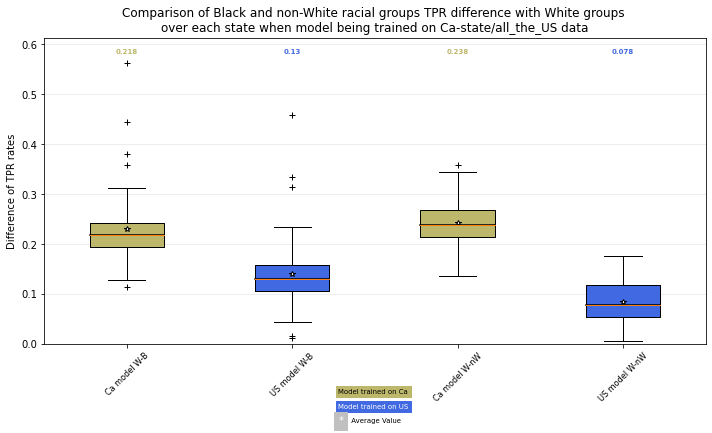

In [35]:
data = [list(dict(diff_tpr_wb_n2).values()), list(dict(diff_tpr_wb_us).values()),
        list(dict(diff_tpr_wn_n2).values()), list(dict(diff_tpr_wn_us).values())]

title='Comparison of Black and non-White racial groups TPR difference with White groups \n' \
          'over each state when model being trained on every-state/all_the_US data'
xlabel=' '
ylabel='Difference of TPR rates'
differences = ['N2 models W-B','US model W-B', 'N2 models W-nW', 'US model W-nW']
leg1='N-Model trains N2 tests'
leg2= 'Model trained on US'
limit = max(list(itertools.chain(*data)))+ 0.05

produce_bp(data, title, xlabel, ylabel, differences, leg1, leg2, limit)